# AutoEncoder

More infos can be found on [Edward Choi youtube](https://www.youtube.com/@mp2893/featured) channel\
KAIST AI504

# Loading Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

# Loading Dataset

In [3]:
mnist_train = dset.MNIST("../../", train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
mnist_test = dset.MNIST("../../", train=False, transform=transforms.ToTensor(), target_transform=None, download=False)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [4]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Model

In [5]:
# build your own autoencoder
# in this case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 28*28),
            nn.Sigmoid()                           # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                      # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)                 # final output. resize to input's size
        return out, encoded


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [8]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [9]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1156
val Loss: 0.0705

Epoch 1/9
----------
train Loss: 0.0673
val Loss: 0.0627

Epoch 2/9
----------
train Loss: 0.0563
val Loss: 0.0515

Epoch 3/9
----------
train Loss: 0.0482
val Loss: 0.0449

Epoch 4/9
----------
train Loss: 0.0414
val Loss: 0.0390

Epoch 5/9
----------
train Loss: 0.0369
val Loss: 0.0354

Epoch 6/9
----------
train Loss: 0.0336
val Loss: 0.0324

Epoch 7/9
----------
train Loss: 0.0308
val Loss: 0.0299

Epoch 8/9
----------
train Loss: 0.0287
val Loss: 0.0280

Epoch 9/9
----------
train Loss: 0.0269
val Loss: 0.0263

Training complete in 1m 37s
Best val Loss: 0.026312


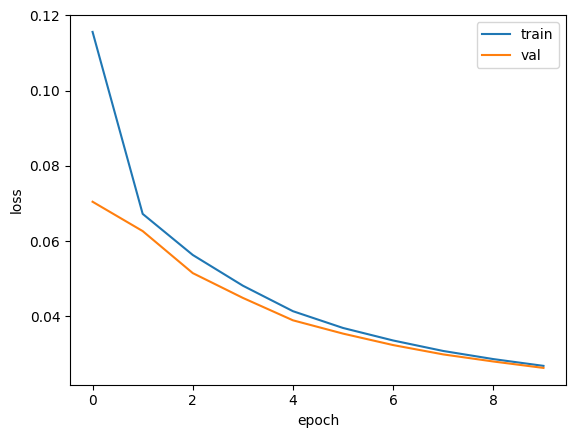

In [10]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Testing

In [11]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.025573117363452913


# AE Reconstruction

torch.Size([16, 28, 28])


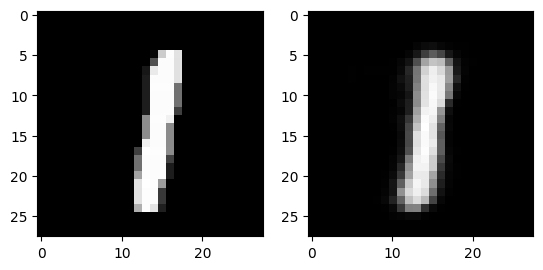

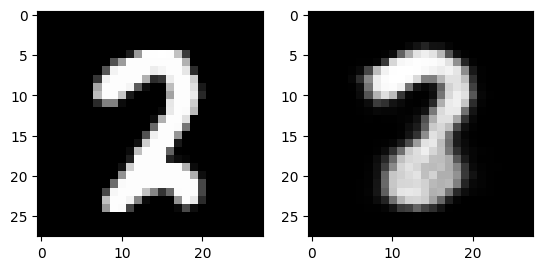

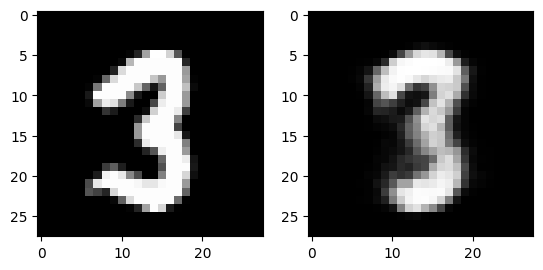

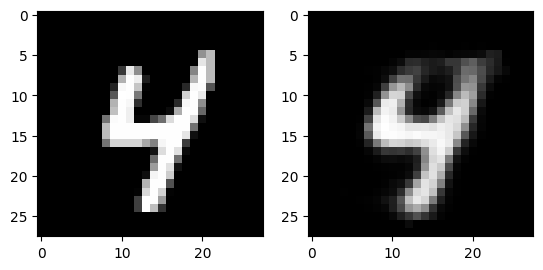

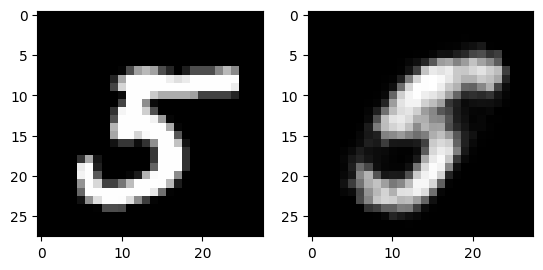

In [12]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

# T-SNE

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [14]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [15]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

In [16]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

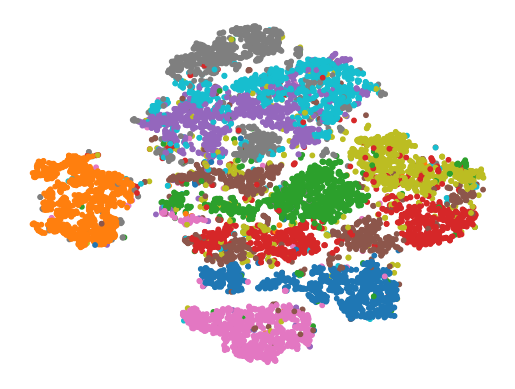

In [17]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

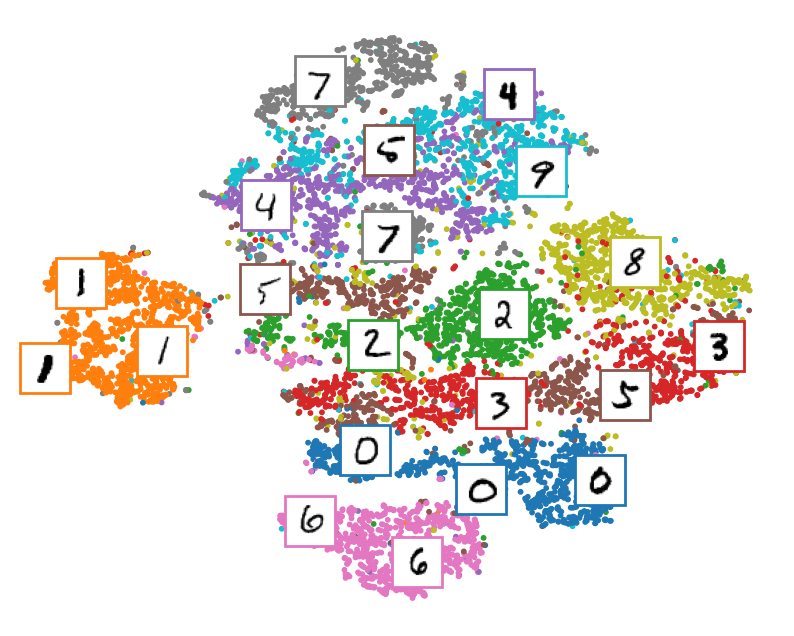

In [18]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()